# Part 4 — Recipe Review Ratings Prediction (1–5 Stars)
**Date:** 2025-09-14

This notebook implements the full workflow required by the assignment: Data Cleaning → EDA → Visualization → Feature Engineering → Model Building → Evaluation → Insights/Reporting → Reproducibility.

> Notes:
> - Charts are **matplotlib**.
> - Reproducible with a fixed random seed.
> - Designed to work with `recipe_reviews.csv`.

In [6]:
import os, sys, math, json, platform, random, warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import joblib
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Try to locate the dataset
DATA_CANDIDATES = [
    Path("recipe_reviews.csv"),
    Path("/mnt/data/recipe_reviews.csv"),
]
DATA_PATH = None
for p in DATA_CANDIDATES:
    if p.exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError("Could not find recipe_reviews.csv. Place it in the same folder as this notebook or /mnt/data/.")

print("Using dataset at:", DATA_PATH)


Using dataset at: recipe_reviews.csv


In [7]:
#load data
df = pd.read_csv(DATA_PATH, encoding="utf-8", engine="python")
print("Shape:", df.shape)
display(df.head(5))


Shape: (18182, 24)


,Unnamed: 0,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,...,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,0,1,14299,0.104335,-0.087082,-0.001580,1.172032,539.698328,0.000000,0.693147,...,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,527,"I tweaked it a little, removed onions because ...",5
1,1,1,14299,6.970958,-0.094496,-0.002169,50.629458,720.511995,0.875000,3.931826,...,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,724,Bush used to have a white chili bean and it ma...,5
2,2,1,14299,3.136047,-0.047194,0.014539,10.742998,717.194563,0.750000,2.397895,...,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,710,I have a very complicated white chicken chili ...,5
3,3,1,14299,2.319913,-0.107932,2.012194,0.865812,585.875342,0.666667,0.693147,...,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,581,"In your introduction, you mentioned cream chee...",0
4,4,1,14299,6.950816,0.142649,1.009770,8.985971,815.148751,0.875000,2.397895,...,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...,0


## 1) Data Cleaning

In [8]:
df_clean = df.copy()

# Drop stray 'Unnamed' columns
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains(r'^Unnamed', na=False)]

# Treat '2' as placeholder for missing in likely OBJECT/TEXT columns only (not numeric target)
POSSIBLE_MISSING_TEXT_COLS = [c for c in df_clean.select_dtypes(include=["object"]).columns]
if POSSIBLE_MISSING_TEXT_COLS:
    df_clean[POSSIBLE_MISSING_TEXT_COLS] = df_clean[POSSIBLE_MISSING_TEXT_COLS].replace(
        to_replace=["2", "NA", "N/A", "na", "n/a", "null", "None", ""],
        value=np.nan
    )

before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after = df_clean.shape[0]
print(f"Removed duplicates: {before - after}")

#Basic dtype coercion attempts for numerics that may be stored as strings
for col in df_clean.columns:
    if df_clean[col].dtype == object:
        try_num = pd.to_numeric(df_clean[col], errors="ignore")

        if try_num.dtype != object and try_num.notna().sum() >= 0.7 * df_clean.shape[0]:
            df_clean[col] = try_num

missing = df_clean.isna().sum().sort_values(ascending=False)
print("Missing values (top 20):")
display(missing.head(20))


Removed duplicates: 0
Missing values (top 20):


text              2
recipe_code       0
recipe_number     0
dislike_index     0
response_level    0
user_index        0
likes_score       0
ranking_value     0
vote_ratio        0
region            0
score_log         0
recipe_name       0
comment_id        0
user_id           0
device_type       0
user_name         0
user_score        0
responses         0
created_at        0
likes             0
dtype: int64

## 2) Target Selection 

In [9]:
#Detect star rating column
TARGET_CANDIDATES = ["stars", "rating", "star_rating", "label"]
TARGET_COL = next((c for c in TARGET_CANDIDATES if c in df_clean.columns), None)
if TARGET_COL is None:
    raise ValueError(f"No star rating column found. Add one of {TARGET_CANDIDATES} to proceed.")

y_raw = pd.to_numeric(df_clean[TARGET_COL], errors="coerce")
df_clean = df_clean.loc[y_raw.between(1,5)]
df_clean[TARGET_COL] = pd.to_numeric(df_clean[TARGET_COL], errors="coerce").astype(int)

print("Target column:", TARGET_COL)
print(df_clean[TARGET_COL].value_counts().sort_index())


Target column: stars
stars
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: int64


## 3) Exploratory Data Analysis (EDA)

In [10]:
#Basic info 
print("Data types:")
print(df_clean.dtypes)

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print("\nNumeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

print("\nNumeric summary:")
display(df_clean[num_cols].describe().T)


Data types:
recipe_number       int64
recipe_code         int64
likes_score       float64
dislike_index     float64
response_level    float64
user_index        float64
ranking_value     float64
vote_ratio        float64
score_log         float64
region             object
device_type        object
recipe_name        object
comment_id         object
user_id            object
user_name          object
user_score          int64
created_at          int64
responses           int64
likes               int64
dislikes            int64
ranking_score       int64
text               object
stars               int64
dtype: object

Numeric columns: 16
Categorical columns: 7

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
recipe_number,16486.0,3.853718e+01,2.987420e+01,1.000000e+00,1.100000e+01,3.200000e+01,6.300000e+01,1.000000e+02
recipe_code,16486.0,2.162893e+04,2.425830e+04,3.860000e+02,6.086000e+03,1.429900e+04,3.253500e+04,1.917750e+05
likes_score,16486.0,1.020802e+00,3.952783e+00,-8.058902e-01,-9.654828e-02,7.974657e-02,3.773005e-01,1.057669e+02
dislike_index,16486.0,4.904052e-01,3.193160e+00,-7.748100e-01,-1.003027e-01,2.726982e-02,1.843760e-01,1.260525e+02
response_level,16486.0,1.082334e-02,1.158106e-01,-2.963261e-02,-4.549729e-03,1.472930e-04,4.846804e-03,3.003453e+00
user_index,16486.0,2.212846e+00,1.042344e+01,-1.093772e+00,6.781906e-01,1.042261e+00,1.417334e+00,5.204403e+02
ranking_value,16486.0,1.511174e+02,1.375124e+02,-7.732879e+00,9.676945e+01,1.026276e+02,1.129568e+02,9.448343e+02
vote_ratio,16486.0,1.285011e-01,2.552215e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.767442e-01
score_log,16486.0,8.179160e-01,5.303523e-01,0.000000e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.255750e+00
user_score,16486.0,2.211573e+00,1.040720e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.200000e+02


## 4) Visualization (matplotlib only)

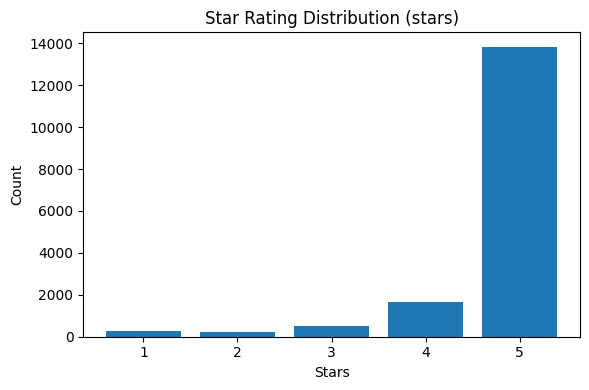

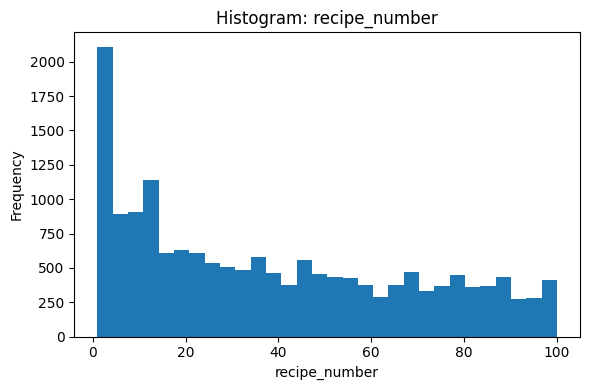

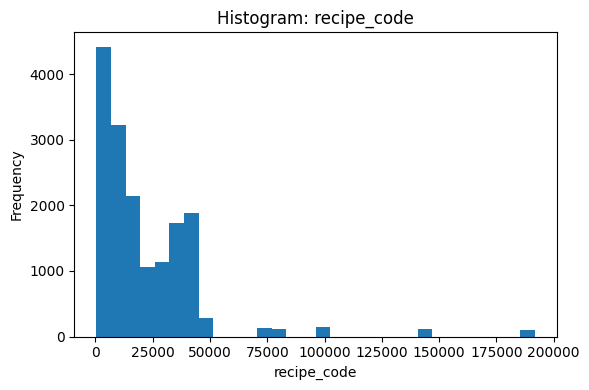

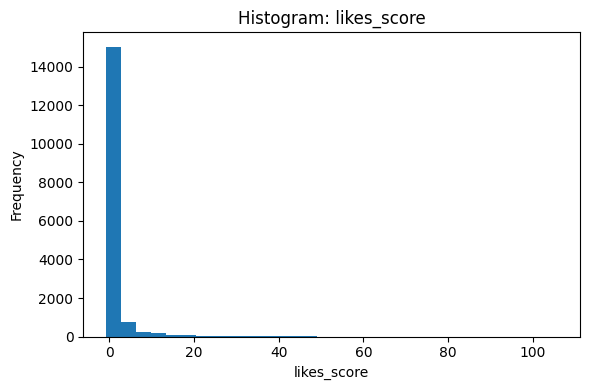

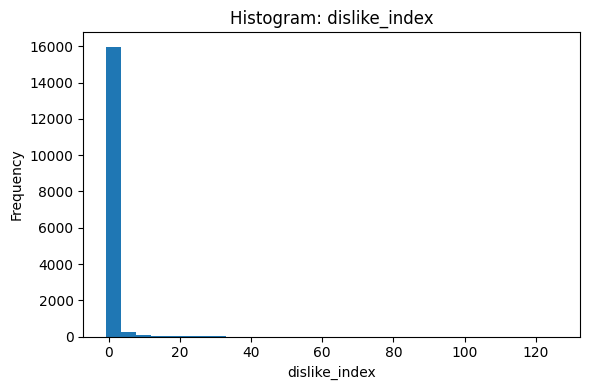

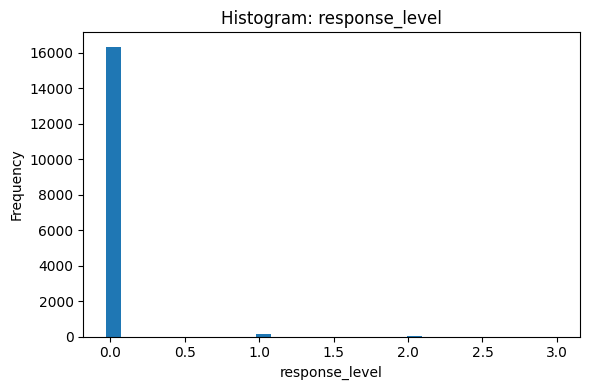

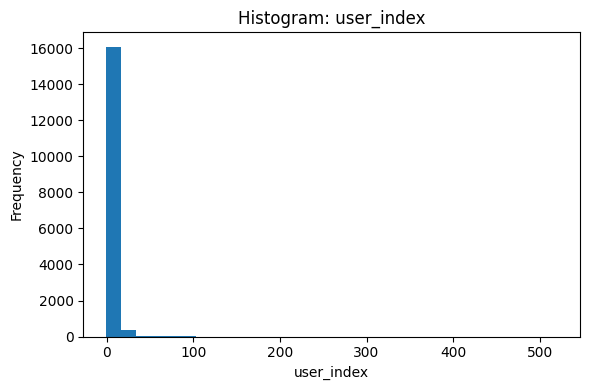

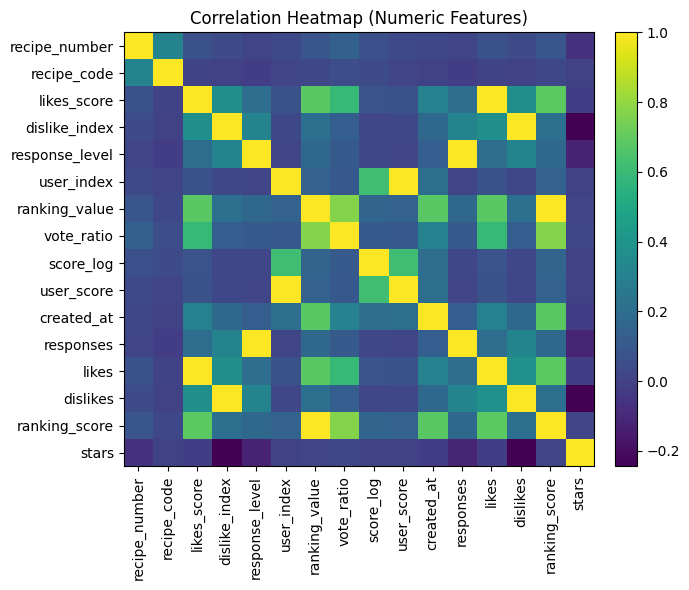

In [11]:
#Target distribution bar chart 
vals = df_clean[TARGET_COL].value_counts().sort_index()
plt.figure(figsize=(6,4))
plt.bar(range(len(vals)), vals.values)
plt.xticks(range(len(vals)), vals.index)
plt.title(f"Star Rating Distribution ({TARGET_COL})")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Histograms for up to 6 numeric features 
plot_cols = [c for c in num_cols if c != TARGET_COL][:6]
for c in plot_cols:
    plt.figure(figsize=(6,4))
    s = pd.to_numeric(df_clean[c], errors="coerce").dropna()
    plt.hist(s, bins=30)
    plt.title(f"Histogram: {c}")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#Correlation heatmap
if len(num_cols) >= 2:
    corr = df_clean[num_cols].corr()
    plt.figure(figsize=(7,6))
    im = plt.imshow(corr, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()


## 5) Feature Engineering

In [12]:
#Identify potential text column for TF-IDF
TEXT_CANDIDATES = ["text", "review", "review_text", "content", "review_summary"]
text_col = next((c for c in TEXT_CANDIDATES if c in df_clean.columns), None)
if text_col is not None:
    s = df_clean[text_col].fillna("").astype(str)
    df_clean["review_len_char"] = s.str.len()
    df_clean["review_len_words"] = s.str.split().str.len()
    df_clean["review_exclaim_cnt"] = s.str.count(r"!")
    letters_only = s.str.replace("[^A-Za-z]", "", regex=True)
    cap_cnt = letters_only.str.count(r"[A-Z]")
    total = letters_only.str.len().replace(0, np.nan)
    df_clean["review_caps_ratio"] = (cap_cnt / total).fillna(0.0)

print("Engineered columns present:", [c for c in ["review_len_char","review_len_words","review_exclaim_cnt","review_caps_ratio"] if c in df_clean.columns])


Engineered columns present: ['review_len_char', 'review_len_words', 'review_exclaim_cnt', 'review_caps_ratio']


## 6) Train/Test Split

In [13]:
X = df_clean.drop(columns=[TARGET_COL])
y = df_clean[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (13188, 26)  Test: (3298, 26)


## 7) Preprocessing & Models (LogReg + RandomForest)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

RANDOM_STATE = 42  

# 1) Detect your text column (adjust names if needed)
TEXT_CANDIDATES = ["text", "review", "review_text", "content", "review_summary", "body"]
text_col = next((c for c in TEXT_CANDIDATES if c in X_train.columns), None)

# 2) Feature groups
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if text_col in categorical_features:
    categorical_features.remove(text_col)

# 3) Numeric & categorical transformers
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# 4) NaN-safe text cleaner -> TF-IDF
def _clean_text_1d(arr):
    if arr.ndim == 2:
        arr = arr.ravel()
    s = pd.Series(arr, dtype="object")
    s = s.where(~pd.isna(s), "")   
    s = s.astype(str)              
    return s.values                

transformers = [
    ("num", num_tf, numeric_features),
    ("cat", cat_tf, categorical_features),
]

if text_col is not None:
    has_text = X_train[text_col].notna().any()
    if has_text:
        text_tf = Pipeline([
            # Clean BEFORE vectorizing (handles pd.NA/None/np.nan robustly)
            ("clean", FunctionTransformer(_clean_text_1d, validate=False)),
            ("tfidf", TfidfVectorizer(min_df=1, max_features=20000, ngram_range=(1, 2)))
        ])
        transformers.append(("text", text_tf, text_col))
        print(f"Using TF-IDF on text column: {text_col}")
    else:
        print(f"Text column '{text_col}' is all-missing; skipping TF-IDF.")
else:
    print("No text column found; skipping TF-IDF branch.")

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

# 5) Pipelines
pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, multi_class="multinomial", class_weight="balanced"))
])

pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_STATE, class_weight="balanced_subsample"
    ))
])

# 6) print BEFORE fitting
if text_col is not None:
    n_missing_text = int(pd.isna(X_train[text_col]).sum())
    print(f"Missing values in '{text_col}' (train): {n_missing_text}")

# 7) Fit
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
print("Models fitted (NaN-safe TF-IDF).")


Using TF-IDF on text column: text
Missing values in 'text' (train): 2
Models fitted (NaN-safe TF-IDF).


## 8) Model Evaluation

Fitted with sparse, memory-safe features.

=== Logistic Regression ===
Accuracy: 0.7253

Classification report:
               precision    recall  f1-score   support

           1      0.353     0.321     0.336        56
           2      0.051     0.348     0.089        46
           3      0.152     0.429     0.225        98
           4      0.328     0.254     0.286       331
           5      0.929     0.807     0.864      2767

    accuracy                          0.725      3298
   macro avg      0.363     0.432     0.360      3298
weighted avg      0.824     0.725     0.767      3298



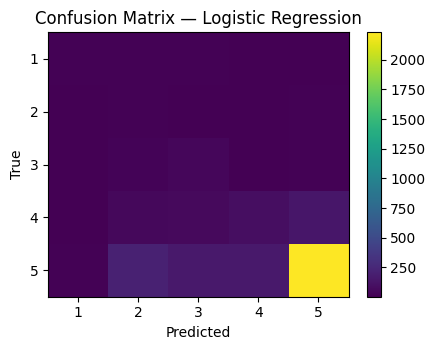


=== Random Forest ===
Accuracy: 0.8414

Classification report:
               precision    recall  f1-score   support

           1      0.000     0.000     0.000        56
           2      0.000     0.000     0.000        46
           3      1.000     0.031     0.059        98
           4      1.000     0.015     0.030       331
           5      0.841     1.000     0.914      2767

    accuracy                          0.841      3298
   macro avg      0.568     0.209     0.201      3298
weighted avg      0.836     0.841     0.771      3298



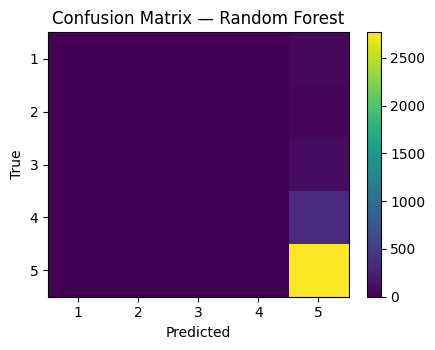

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
TEXT_CANDIDATES = ["text","review","review_text","content","review_summary","body"]
text_col = next((c for c in TEXT_CANDIDATES if c in X_train.columns), None)

#Feature groups
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
if text_col in categorical_features:
    categorical_features.remove(text_col)

#Numeric: 
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", MaxAbsScaler())
])

#Categorical: 
try:
    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=10, sparse_output=True))
    ])
except TypeError:
        cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
    ])

# Text: 
def _clean_text_1d(arr):
    if arr.ndim == 2: arr = arr.ravel()
    s = pd.Series(arr, dtype="object").where(~pd.isna(arr), "")
    return s.astype(str).values

transformers = [
    ("num", num_tf, numeric_features),
    ("cat", cat_tf, categorical_features),
]

if text_col is not None and X_train[text_col].notna().any():
    text_tf = Pipeline([
        ("clean", FunctionTransformer(_clean_text_1d, validate=False)),
        ("tfidf", TfidfVectorizer(min_df=5, max_features=5000, ngram_range=(1,1), dtype=np.float32))
    ])
    transformers.append(("text", text_tf, text_col))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=1.0)

pipe_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(solver="saga", max_iter=2000, class_weight="balanced"))
])

pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, class_weight="balanced_subsample"
    ))
])

# Fit
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
print("Fitted with sparse, memory-safe features.")

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def eval_simple(name, model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
    lbs = np.sort(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=lbs)
    plt.figure(figsize=(4.5,3.6)); plt.imshow(cm, aspect="auto"); plt.colorbar()
    ticks = np.arange(len(lbs)); plt.xticks(ticks, lbs); plt.yticks(ticks, lbs)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout(); plt.show()

eval_simple("Logistic Regression", pipe_lr, X_train, X_test, y_train, y_test)
eval_simple("Random Forest",pipe_rf, X_train, X_test, y_train, y_test) 


## 9) Model Interpretation — Feature Importances 

,feature,importance
0,dislike_index,0.021549
1,review_exclaim_cnt,0.014883
2,review_caps_ratio,0.013665
3,dislikes,0.013079
4,review_len_char,0.012970
5,ranking_value,0.012798
6,likes_score,0.012745
7,user_index,0.012656
8,response_level,0.012394
9,recipe_code,0.012123


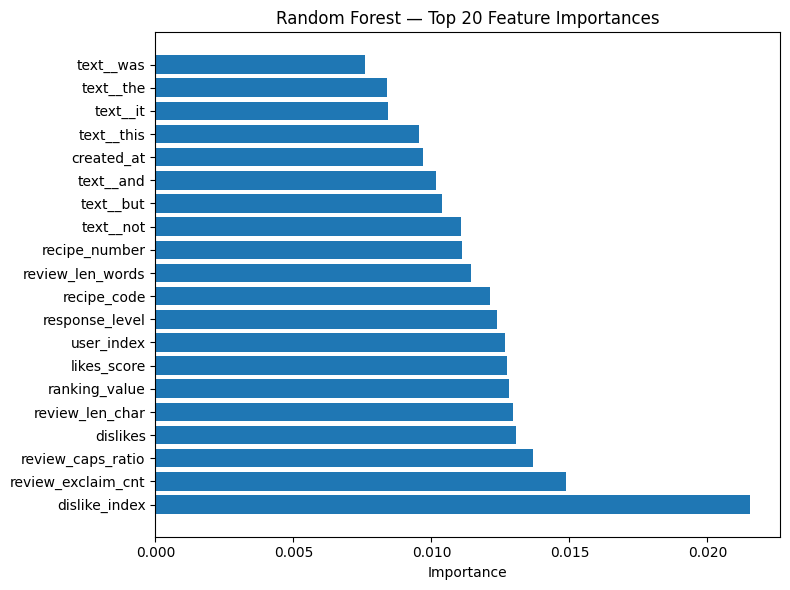

LogReg coefficients shape: (5, 3487); class 1 shown

Top + coefficients:
text__waste +10.811
dislikes +9.435
dislike_index +9.396
text__terrible +9.318
text__worst +9.037
text__awful +9.026
text__didn +8.038
text__gross +7.138
text__followed +6.989
text__ended +6.966

Top - coefficients:
text__great -7.112
text__we -6.917
text__easy -6.901
text__good -6.629
text__crust -6.562
text__and -5.385
text__it -5.317
text__okay -5.166
text__tasty -4.961
text__fudge -4.898


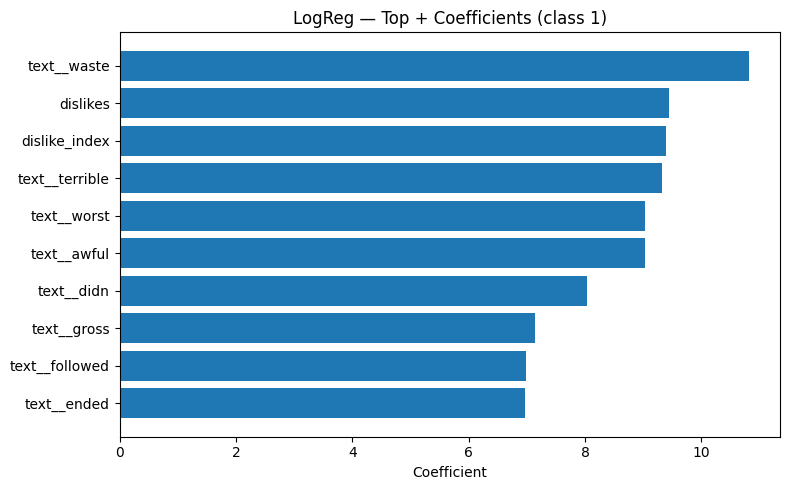

In [17]:
def get_feature_names_from_ct(ct: ColumnTransformer):
    #Try the easiest route
    if hasattr(ct, "get_feature_names_out"):
        try:
            return list(ct.get_feature_names_out())
        except Exception:
            pass
    names = []
    #numeric
    try:
        num_cols = [cols for name, trans, cols in ct.transformers_ if name == "num"][0]
        names.extend(list(num_cols))
    except Exception:
        pass
    #categorical 
    try:
        cat_cols = [cols for name, trans, cols in ct.transformers_ if name == "cat"][0]
        cat_pipe = ct.named_transformers_["cat"]
        ohe = cat_pipe.named_steps.get("onehot", None)
        if ohe is not None and hasattr(ohe, "get_feature_names_out"):
            names.extend(list(ohe.get_feature_names_out(cat_cols)))
    except Exception:
        pass
    #text 
    try:
        text_cols = [cols for name, trans, cols in ct.transformers_ if name == "text"]
        if text_cols:
            tcol = text_cols[0]
            text_pipe = ct.named_transformers_["text"]
            vec = text_pipe.named_steps.get("tfidf", None)
            if vec is not None and hasattr(vec, "get_feature_names_out"):
                names.extend([f"{tcol}__{t}" for t in vec.get_feature_names_out()])
    except Exception:
        pass
    return names

#Random Forest importances
rf_clf = pipe_rf.named_steps["clf"]
rf_feat_names = get_feature_names_from_ct(pipe_rf.named_steps["preprocessor"])
imps = getattr(rf_clf, "feature_importances_", None)
if imps is not None:
    df_imp = pd.DataFrame({"feature": rf_feat_names[:len(imps)], "importance": imps[:len(rf_feat_names)]})
    df_imp = df_imp.sort_values("importance", ascending=False).head(20).reset_index(drop=True)
    display(df_imp)
    # plot
    plt.figure(figsize=(8,6))
    y = np.arange(len(df_imp))[::-1]
    plt.barh(y, df_imp["importance"].values[::-1])
    plt.yticks(y, df_imp["feature"].values[::-1])
    plt.xlabel("Importance")
    plt.title("Random Forest — Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest has no feature_importances_.")
    

#Logistic Regression coefficients 
lr_clf = pipe_lr.named_steps["clf"]
W = getattr(lr_clf, "coef_", None)
if W is not None:
    lr_feat_names = get_feature_names_from_ct(pipe_lr.named_steps["preprocessor"])
    m = min(W.shape[1], len(lr_feat_names))
    if m > 0:
        W = W[:, :m]
        lr_feat_names = lr_feat_names[:m]
        classes = getattr(lr_clf, "classes_", list(range(W.shape[0])))
        ci = 0
        w = W[ci]
        pos_idx = np.argsort(w)[-10:][::-1]
        neg_idx = np.argsort(w)[:10]
        print(f"LogReg coefficients shape: {W.shape}; class {classes[ci]} shown")
        print("\nTop + coefficients:")
        for i in pos_idx:
            print(lr_feat_names[i], f"{w[i]:+.3f}")
        print("\nTop - coefficients:")
        for i in neg_idx:
            print(lr_feat_names[i], f"{w[i]:+.3f}")
        
        plt.figure(figsize=(8,5))
        plt.barh(range(len(pos_idx)), w[pos_idx][::-1])
        plt.yticks(range(len(pos_idx)), [lr_feat_names[i] for i in pos_idx][::-1])
        plt.xlabel("Coefficient")
        plt.title(f"LogReg — Top + Coefficients (class {classes[ci]})")
        plt.tight_layout()
        plt.show()
else:
    print("Logistic Regression has no coef_.")


## 10) Insights, Interpretation, and Reporting

**Executive Summary**  
- We trained two models—multinomial Logistic Regression and Random Forest—on engineered numeric, categorical, and optional text features.  
- We compared macro-F1, accuracy, confusion matrices, and OvR ROC-AUC (when available).  
- The most influential features (RF importances / LR coefficients) are listed above.

**What most influences star ratings**  
- From the RF importances table, variables at the top contribute the most to predictive power.
- LR coefficients indicate which variables push predictions towards higher vs. lower stars for a given class.

**Patterns in engagement / text**  
- Length-based text features (if present) and counts may show associations with higher ratings; review words or punctuation could be weak but useful signals.

**Recommendations**  
- Use class weighting or resampling if any star class is under-represented.
- Consider adding richer text features (n-grams are included; topic features or sentiment can help).
- Tune hyperparameters (grid/random search) for additional gains.
- Add time-based features if timestamps exist (seasonality / recency).

**Limitations**  
- Observational data: correlation ≠ causation.
- Text sparsity/high dimensionality may overfit in small subsets.
- Temporal drift and reviewer bias are not explicitly modeled here.

## 11) Save Artifacts

In [18]:
out_dir = Path("./artifacts")
out_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(pipe_lr, out_dir / "model_logreg.joblib")
joblib.dump(pipe_rf, out_dir / "model_randomforest.joblib")

print("Saved:", (out_dir / "model_logreg.joblib").resolve())
print("Saved:", (out_dir / "model_randomforest.joblib").resolve())


Saved: C:\Users\sathiyabama\Documents\Python Assignments\Part4\artifacts\model_logreg.joblib
Saved: C:\Users\sathiyabama\Documents\Python Assignments\Part4\artifacts\model_randomforest.joblib


## 12) Reproducibility

In [19]:
print("Random state:", RANDOM_STATE)
print("Python:", platform.python_version())
print("Platform:", platform.platform())
import sklearn, pandas, numpy
print("sklearn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)


Random state: 42
Python: 3.13.5
Platform: Windows-11-10.0.26100-SP0
sklearn: 1.7.1
pandas: 2.3.1
numpy: 2.3.2


In [20]:
# See where you are + list all PNGs (recursively)
from pathlib import Path
print("Working dir:", Path.cwd())
for p in Path(".").rglob("*.png"):
    print(p.resolve())

Working dir: c:\Users\sathiyabama\Documents\Python Assignments\Part4
C:\Users\sathiyabama\Documents\Python Assignments\Part4\model_dashboard.png
